In [9]:
import numpy as np
import matplotlib.pyplot as plt
from copy import copy
from numpy.fft import fft,fftshift
plt.rcParams.update({'font.size': 16})

from matplotlib.axes import Subplot as _Subplot
from matplotlib.gridspec import SubplotSpec as _SubplotSpec
if hasattr(_SubplotSpec,'is_first_col'):
    def _fun(self):
        return self.get_subplotspec().is_first_col()
    _Subplot.is_first_col=_fun
    def _fun(self):
        return self.get_subplotspec().is_first_row()
    _Subplot.is_first_row=_fun
    def _fun(self):
        return self.get_subplotspec().is_last_col()
    _Subplot.is_last_col=_fun
    def _fun(self):
        return self.get_subplotspec().is_last_row()
    _Subplot.is_last_row=_fun

In [3]:
%matplotlib notebook

In [4]:
SW=200
TD=640
SI=2048
SF=150
O=100


SWH=SF*SW
dt=1/SWH

artifacts=.03*(1)

In [5]:
A,delta1,lw1,delta2,lw2=[[] for _ in range(5)]
with open('peaks.txt','r') as f:
    for line in f:
        i,d1,l1,d2,l2=[float(x) for x in line.strip().split('\t')]
        A.append(i)
        delta1.append(d1)
        lw1.append(l1)
        delta2.append(d2)
        lw2.append(l2)
A,delta1,lw1,delta2,lw2=[np.array(x) for x in [A,delta1,lw1,delta2,lw2]]


vr=12000
i=np.logical_and(delta1>140,delta2>140)
A=np.concatenate([A,.1*A[i],.1*A[i],.03*A[i],.03*A[i],.03*A[i]])
delta1=np.concatenate([delta1,delta1[i],delta1[i]-vr/SF,delta1[i],delta1[i]-2*vr/SF,delta1[i]-vr/SF])
delta2=np.concatenate([delta2,delta2[i]-vr/SF,delta2[i],delta2[i]-2*vr/SF,delta2[i],delta2[i]-vr/SF])
lw1=np.concatenate([lw1,lw1[i],lw1[i],lw1[i],lw1[i],lw1[i]])
lw2=np.concatenate([lw2,lw2[i],lw2[i],lw2[i],lw2[i],lw2[i]])


nl=A.max()/3

In [6]:
t=np.arange(TD)*dt

RR,RI,IR,II=[np.zeros((TD,TD),dtype=complex) for _ in range(4)]

for i,d1,l1,d2,l2 in zip(A,delta1,lw1,delta2,lw2):
    RR+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.real*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)
    IR+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.imag*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).real)
    RI+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.real*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    II+=i*np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d1-O)-l1)*t)).T.imag*\
        np.atleast_2d(np.exp(np.pi*SF*(1j*2*(d2-O)-l2)*t).imag)
    
I0=[RR,IR,RI,II]
titles=['real/real','real/imag','imag/real','imag/imag']

<IPython.core.display.Javascript object>


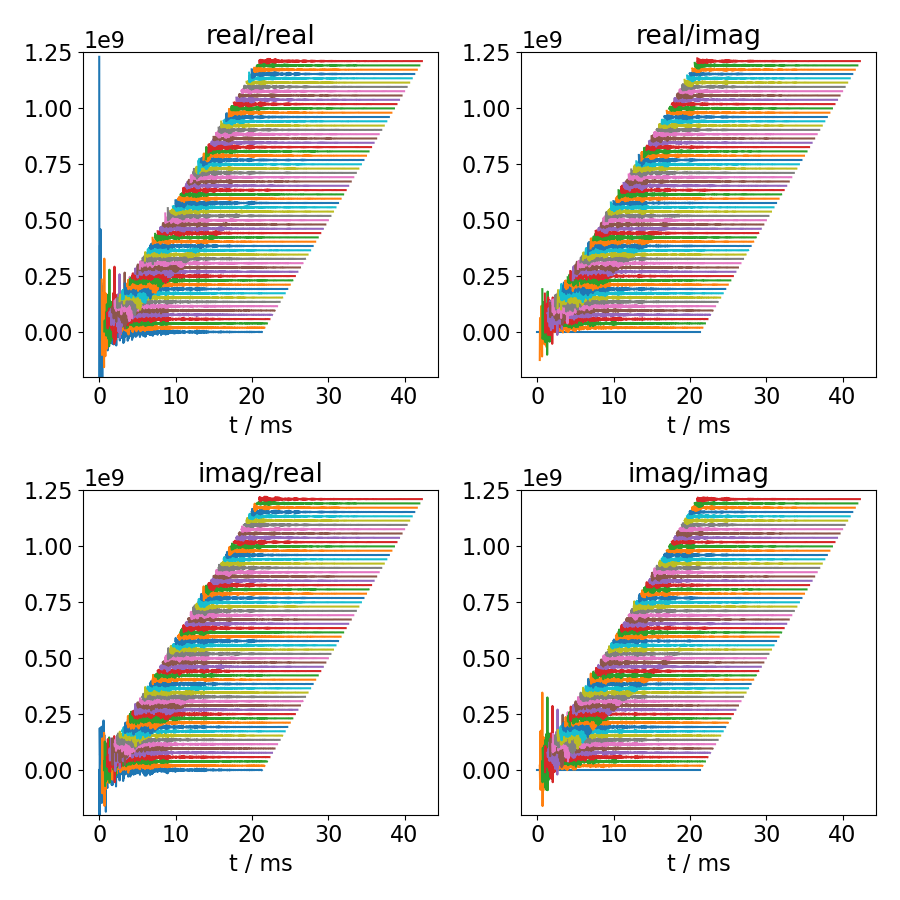

In [7]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
skip=10
for I,a,title in zip(I0,ax,titles):
    for k,I1 in enumerate(I[::skip]):
        a.plot((t+t[-1]*k/len(I[::skip]))*1e3,I1.real+k*RR.real.max()/len(I[::skip]))
    a.set_title(title)
    a.set_xlabel('t / ms')
    a.set_ylim([-.2e9,1.25e9])
fig.set_size_inches([9,9])
fig.tight_layout()
        

We'll keep the four signals (real/real, real/imaginary, imaginary/real, imaginary/imaginary) separate, rather than using complex data.

## Step 1: Divide first time point by two in direct dimension and apodize
We use a cosine-squared (QSINE with SSB=2) apodization function

<IPython.core.display.Javascript object>


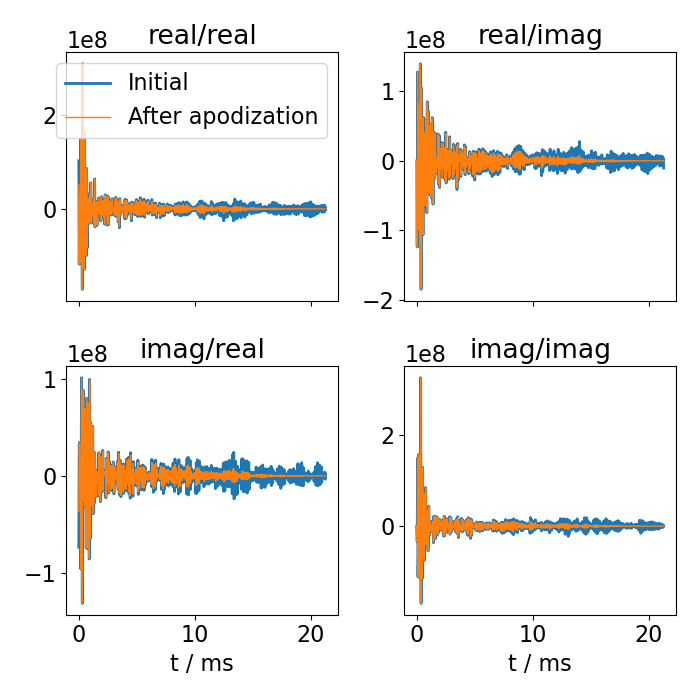

In [10]:
apod=np.cos(np.arange(TD)/TD*np.pi/2)**2

fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for I,a,title in zip(I0,ax,titles):
    a.plot(t*1e3,I[:,10].real,linewidth=2)
    I[0]/=2 #Divide first time point by 2
    I=(I.T*apod).T
    a.plot(t*1e3,I[:,10].real,linewidth=1)
    a.set_title(title)
    if a.is_last_row():
        a.set_xlabel('t / ms')
    else:
        a.set_xticklabels('')
ax[0].legend(('Initial','After apodization'))
fig.set_size_inches([7,7])
fig.tight_layout()

## Step 2: Fourier transform the direct dimension
Use a size at least twice the size of the original time-domain data, so that all information is stored in the real component of the resulting Fourier transform

<IPython.core.display.Javascript object>


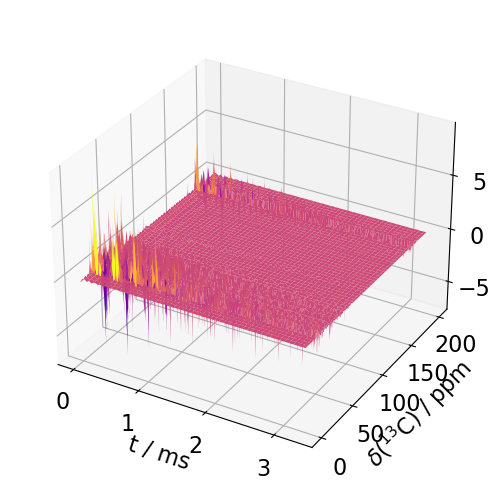

In [11]:
S0_R=fftshift(fft(RR+1j*IR,SI,axis=0),0)
S0_I=fftshift(fft(RI+1j*II,SI,axis=0),0)

S0=[S0_R.real,S0_R.imag,S0_I.real,S0_I.imag]

f=1/(2*dt)*np.linspace(-1,1,SI)
f-=np.diff(f[:2])/2

ax=plt.figure().add_subplot(111,projection='3d')
fig=ax.figure
ax.plot_surface(*np.meshgrid(t[:100]*1e3,f/SF+O),S0[0][:,:100],cmap=plt.get_cmap('plasma'))
ax.set_xlabel('t / ms')
ax.set_ylabel(r'$\delta$($^{13}$C) / ppm')

    
fig.set_size_inches([5,5])
fig.tight_layout()

## Step 3: Divide first time point by two in the indirect dimension and apodize

<IPython.core.display.Javascript object>


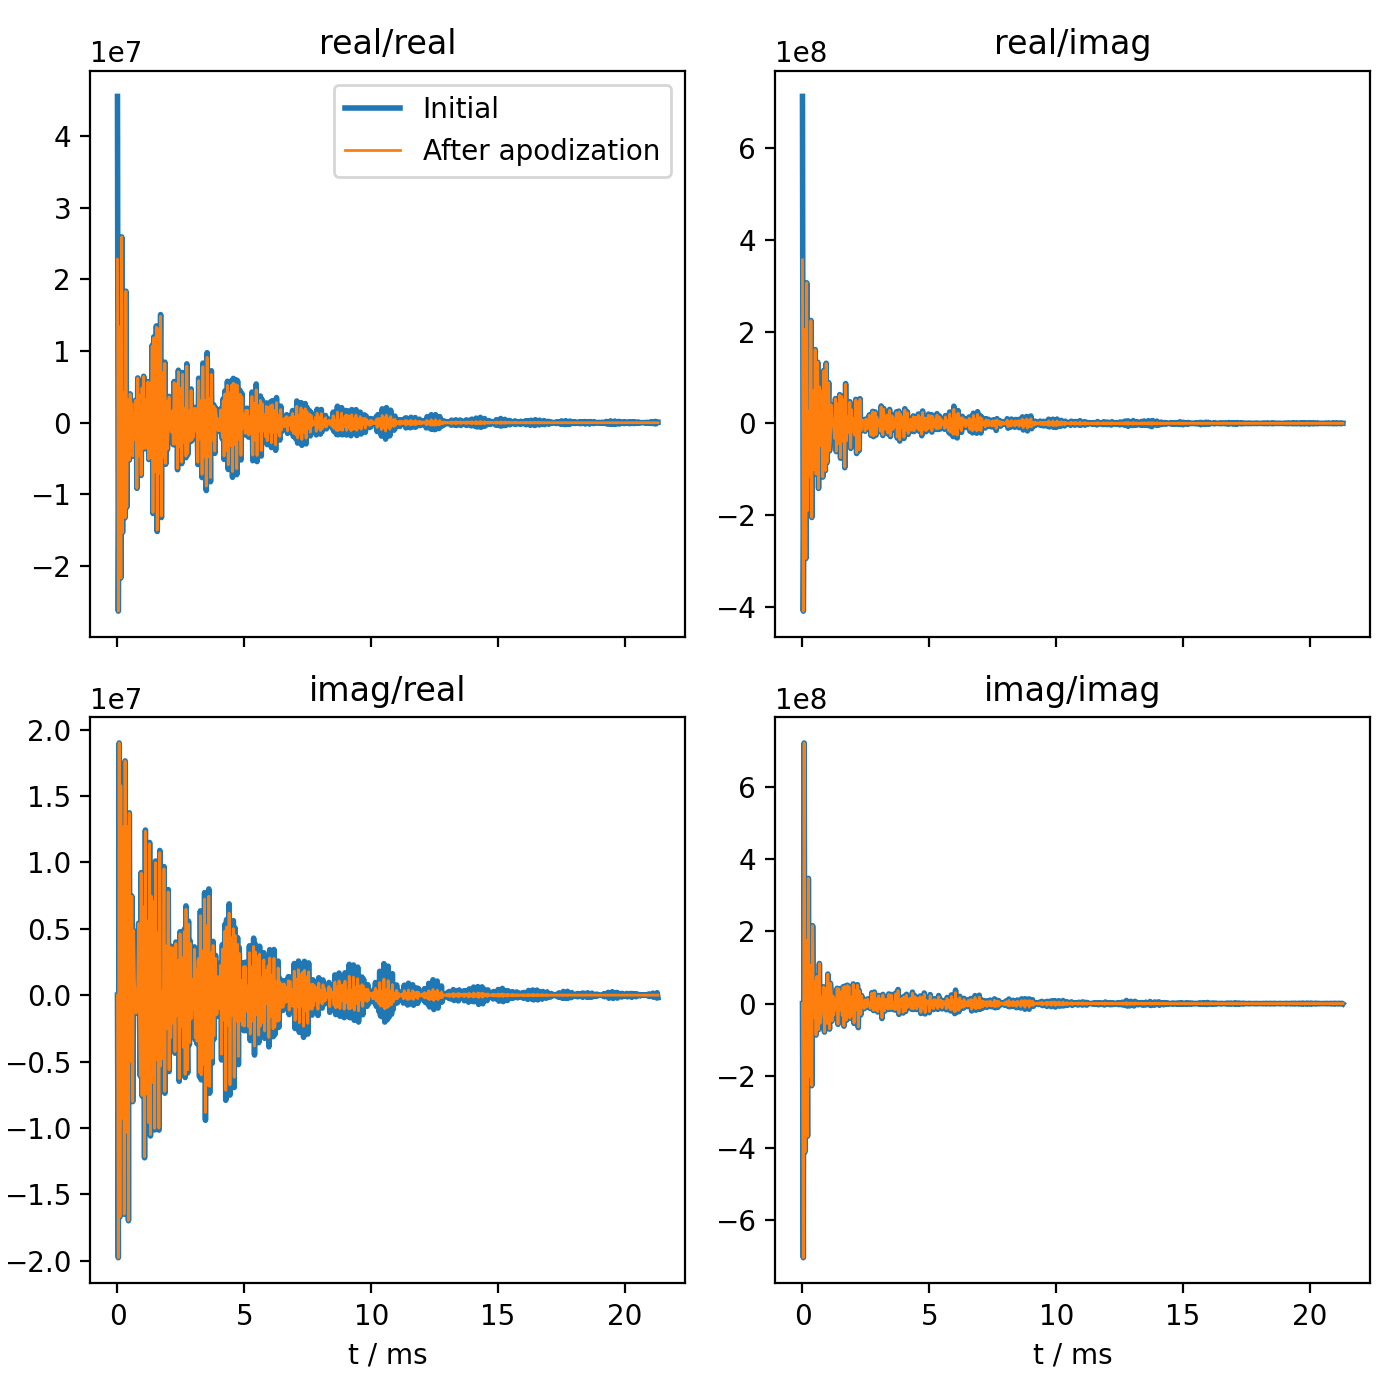

In [78]:
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for S,a,title in zip(S0,ax,titles):
    a.plot(t*1e3,S[10,:].real,linewidth=2)
    S[:,0]/=2 #Divide first time point by 2
    S=S*apod
    a.plot(t*1e3,S[10,:].real,linewidth=1)
    a.set_title(title)
    if a.is_last_row():
        a.set_xlabel('t / ms')
    else:
        a.set_xticklabels('')
ax[0].legend(('Initial','After apodization'))
fig.set_size_inches([7,7])
fig.tight_layout()

## Step 4: Fourier transform direct dimension 

In [20]:
#S0=[S0_R.real,S0_R.imag,S0_I.real,S0_I.imag]
S=[fftshift(fft(S0[0]+1j*S0[2],SI),-1).real,fftshift(fft(S0[0]+1j*S0[2],SI),-1).imag,
   fftshift(fft(S0[1]+1j*S0[3],SI),-1).real,fftshift(fft(S0[1]+1j*S0[3],SI),-1).imag]

<IPython.core.display.Javascript object>


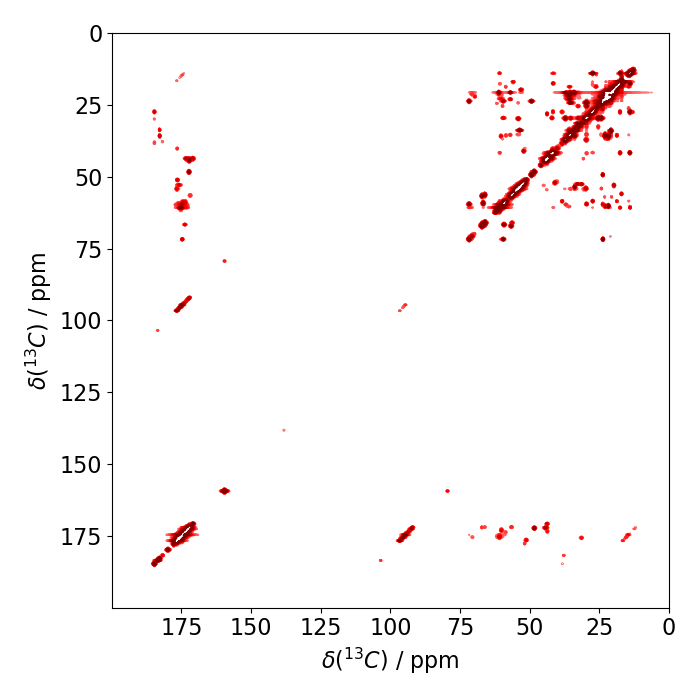

In [35]:
cmap=plt.get_cmap('seismic')
fig,ax=plt.subplots()
levels=np.logspace(np.log10(S[0].max()*A.min()/A.max()*3),np.log10(S[0].max()/50),25)
levels=np.concatenate((-levels[::-1],levels))
ax.contour(f/SF+O,f/SF+O,S[0],levels=levels,cmap=cmap)
ax.invert_xaxis()
ax.invert_yaxis()
ax.set_xlabel(r'$\delta$($^{13}C$) / ppm')
ax.set_ylabel(r'$\delta$($^{13}C$) / ppm')
fig.set_size_inches([7,7])
fig.tight_layout()

<IPython.core.display.Javascript object>


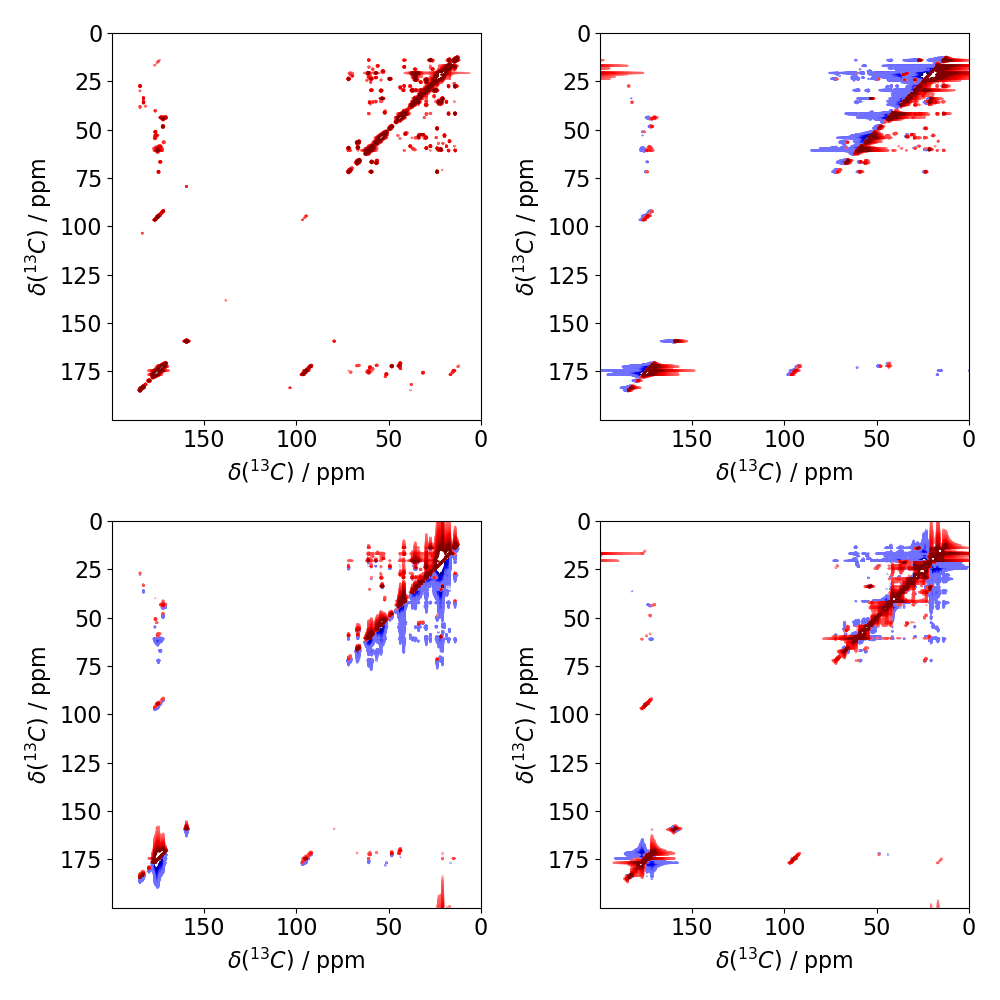

In [36]:
cmap=plt.get_cmap('seismic')
fig,ax=plt.subplots(2,2)
ax=ax.flatten()
for S1,a in zip(S,ax):
    a.contour(f/SF+O,f/SF+O,S1,levels=levels,cmap=cmap)
    a.invert_xaxis()
    a.invert_yaxis()
    a.set_xlabel(r'$\delta$($^{13}C$) / ppm')
    a.set_ylabel(r'$\delta$($^{13}C$) / ppm')
fig.set_size_inches([10,10])
fig.tight_layout()

In [16]:
S1.shape

(2048, 640)